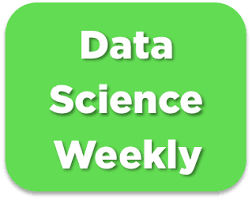

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [ ]:
import pandas as pd
import plotly.express as px
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, TunedThresholdClassifierCV
from sklearn.metrics import f1_score, precision_score, recall_score , confusion_matrix

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

import joblib

# Read file with labels

In [ ]:
data = pd.read_csv('../data/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

In [ ]:
data.head()

# Dataset Exploratory Analysis

In [ ]:
data.shape
data.info()
data.describe(include='all')

In [ ]:
converted_perc_df = (data.value_counts('converted')/data.shape[0]).round(2)
converted_perc_df.index = ['Not converted','Converted']
converted_perc_df.rename('percentage', inplace=True)
px.pie(converted_perc_df, values='percentage', names=converted_perc_df.index, title='Conversion rate')

In [ ]:
fig = px.bar(converted_perc_df, x=converted_perc_df.index, y=converted_perc_df.values, color=converted_perc_df.index)
fig.update_layout(yaxis_title='Visitors', xaxis_title='Conversion', title='Conversion distribution')
fig.show()

In [ ]:
age_converted = data.groupby('age')['converted'].mean().sort_values(ascending=False)
fig = px.bar(x=age_converted.index, y=age_converted.values)
fig.update_layout(yaxis_title='Conversion rate', xaxis_title='Age', title='Conversion rate by age')
fig.show()

In [ ]:
age_converted = data[data['age'] < 62].groupby('age')['converted'].mean().sort_values(ascending=False)
fig = px.bar(x=age_converted.index, y=age_converted.values)
fig.update_layout(yaxis_title='Conversion rate', xaxis_title='Age', title='Conversion rate by age restricted to < 62')
fig.show()

In [ ]:
age_visit = data[data['age'] < 62].groupby('age')['total_pages_visited'].mean().sort_values(ascending=False)
fig = px.bar(x=age_visit.index, y=age_visit.values)
fig.update_layout(yaxis_title='Pages visited', xaxis_title='Age', title='Pages visited by age')
fig.show()

In [ ]:
fig = px.histogram(data[data['age'] < 62], x='age', nbins=45)
fig.update_layout(yaxis_title='Visitors', xaxis_title='Age', title='Age distribution')
fig.update_layout(xaxis=dict(tickvals=list(range(17, 62)),tickmode='array'))
fig.show()

In [ ]:
fig = px.histogram(data, x='total_pages_visited', nbins=30)
fig.update_layout(yaxis_title='Visitors', xaxis_title='Pages visited', title='Pages visited distribution')
fig.update_layout(xaxis=dict(tickvals=list(range(1, 30)),tickmode='array'))
fig.show()

In [ ]:
page_visited_converted = data.groupby('total_pages_visited')['converted'].mean().sort_values(ascending=False)
fig = px.bar(x=page_visited_converted.index, y=page_visited_converted.values)
fig.update_layout(yaxis_title='Conversion rate', xaxis_title='Pages visited', title='Conversion rate by pages visited')
fig.show()

In [ ]:
new_user_converted = data.groupby('new_user')['converted'].mean().sort_values(ascending=False)
new_user_converted.index = ['Old user', 'New user']
fig = px.bar(x=new_user_converted.index, y=new_user_converted.values, color=new_user_converted.index)
fig.update_layout(yaxis_title='Conversion rate', xaxis_title='New user', title='Conversion rate by new user')
fig.show()

In [ ]:
fig = px.histogram(data, x='source', color='source')
fig.update_layout(yaxis_title='Visitors', xaxis_title='Source', title='Source distribution')
fig.show()

In [ ]:
source_converted = data.groupby('source')['converted'].mean().sort_values(ascending=False).round(2)
fig = px.bar(x=source_converted.index, y=source_converted.values, color=source_converted.index)
fig.update_layout(yaxis_title='Conversion rate', xaxis_title='Source', title='Conversion rate by source')
fig.show()

In [ ]:
fig = px.histogram(data, x='country', color='country')
fig.update_layout(yaxis_title='Visitors', xaxis_title='Country', title='Country distribution')
fig.show()

In [ ]:
converted_perc_df = data.groupby('country')['converted'].mean().sort_values(ascending=False).round(2)
fig = px.bar(x=converted_perc_df.index, y=converted_perc_df.values, color=converted_perc_df.index)
fig.update_layout(yaxis_title='Conversion rate', xaxis_title='Country', title='Conversion rate by country')
fig.show()

# Make your model

## Choose variables to use in the model, and create train and test sets

In [ ]:
print(data.columns)

In [ ]:
features_list = ['country', 'age', 'new_user', 'total_pages_visited']
target_variable = 'converted'

In [ ]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]
print('Explanatory variables : ', X.columns)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)

## Training pipeline

In [ ]:
categorical_features = X.select_dtypes(include=['object']).columns
categorical_encoder = OneHotEncoder()
categorical_pipeline = Pipeline([
    ('encoder', categorical_encoder)
])

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
numerical_encoder = StandardScaler()
numerical_pipeline = Pipeline([
    ('encoder', numerical_encoder)
])

preprocessing = ColumnTransformer([
    ("numerical", numerical_pipeline, numerical_features),
    ("categorical", categorical_pipeline, categorical_features)
])

X_train = preprocessing.fit_transform(X_train)
X_test = preprocessing.transform(X_test)

## Baseline models

In [ ]:
models = []

In [ ]:
base_models = {
    'LogisticRegression' : LogisticRegression(random_state=42),
    'DecisionTreeClassifier' : DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier' : RandomForestClassifier(random_state=42, verbose=0),
    'KNeighborsClassifier' : KNeighborsClassifier(),
    'XGBClassifier' : XGBClassifier(random_state=42),
    'LGBMClassifier' : LGBMClassifier(random_state=42, verbose=0),
    'CatBoostClassifier' : CatBoostClassifier(random_state=42, verbose=0, train_dir=r'..\models'),
}

for name, model in base_models.items():
    print(f'Training {name}...')

    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    models.append({'model': f"{name}",
                   'optimizer': 'Baseline', 
                   'f1': f1_score(Y_test, Y_pred), 
                   'precision': precision_score(Y_test, Y_pred), 
                   'recall': recall_score(Y_test, Y_pred), 
                   'parameters': model.get_params()})
    
    print(f"For baseline {name} model :")
    print(f"F1-score : {f1_score(Y_test, Y_pred):.4f}")

In [ ]:
barplot = px.bar(pd.DataFrame(models).sort_values('f1', ascending=False), x='model', y='f1', color='model')
barplot.update_layout(yaxis_title='f1', xaxis_title='', yaxis_range=[0.70, 0.78], title='Baseline f1 score by model')
barplot.show()

## Search for hyperparameters

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
dtc_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 500],
}

dtc_model = LogisticRegression(random_state=42)

random_search = RandomizedSearchCV(dtc_model, dtc_grid, cv=kf, scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}, refit='f1', n_jobs=-1)
random_search.fit(X_train, Y_train)

models.append({'model': 'LogisticRegression',
               'optimizer': 'RandomizedSearchCV', 
               'f1': random_search.best_score_,
               'precision': random_search.cv_results_['mean_test_precision'][random_search.best_index_],
               'recall': random_search.cv_results_['mean_test_recall'][random_search.best_index_],
               'parameters': random_search.best_params_})

print("model LogisticRegression")
print(f"best score : {random_search.best_score_}")
print("")
for param, value in random_search.best_params_.items():
    print(param, ":", value)

In [ ]:
def LogisticRegression_tuning(trial):

  param_grid = {
      'penalty': 'l2',
      'C': trial.suggest_float('C', 0.001, 100),
      'solver': 'lbfgs',
      'max_iter': trial.suggest_int('max_iter', 100, 500),
      'random_state': 42,
    }
  
  model = LogisticRegression(**param_grid, verbose=0)

  model.fit(X_train, Y_train)

  return model.score(X_test, Y_test)

LogisticRegression_study = optuna.create_study(direction='maximize')
LogisticRegression_study.optimize(LogisticRegression_tuning, n_trials=50, n_jobs=-1, timeout=600)

model = LogisticRegression(**LogisticRegression_study.best_params, verbose=0)

model.fit(X_train, Y_train)

models.append({'model': 'LogisticRegression',
               'optimizer': 'Optuna', 
               'f1': f1_score(Y_test, model.predict(X_test)),
               'precision': precision_score(Y_test, model.predict(X_test)),
               'recall': recall_score(Y_test, model.predict(X_test)),
               'parameters': model.get_params()})

print("model LogisticRegression")
print(f"best score : {f1_score(Y_test, model.predict(X_test))}")
print("")
for param, value in LogisticRegression_study.best_trial.params.items():
    print(param, ":", value)

In [ ]:
dtc_grid = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_depth': [None, 5, 10, 20],
    'criterion': ['gini', 'entropy'],
}


dtc_model = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dtc_model, dtc_grid, cv=kf, scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}, refit='f1', n_jobs=-1)
random_search.fit(X_train, Y_train)

models.append({'model': 'DecisionTreeClassifier',
               'optimizer': 'RandomizedSearchCV', 
               'f1': random_search.best_score_,
               'precision': random_search.cv_results_['mean_test_precision'][random_search.best_index_],
               'recall': random_search.cv_results_['mean_test_recall'][random_search.best_index_],
               'parameters': random_search.best_params_})

print("model DecisionTreeClassifier")
print(f"best score : {random_search.best_score_}")
print("")
for param, value in random_search.best_params_.items():
    print(param, ":", value)

In [ ]:
def DecisionTreeClassifier_tuning(trial):

  param_grid = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'max_depth': trial.suggest_int('max_depth', 1, 500),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 200),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 200),
        'random_state': 42,
    }
  
  model = DecisionTreeClassifier(**param_grid)

  model.fit(X_train, Y_train)

  return model.score(X_test, Y_test)

DecisionTreeClassifier_study = optuna.create_study(direction='maximize')
DecisionTreeClassifier_study.optimize(DecisionTreeClassifier_tuning, n_trials=50, n_jobs=-1, timeout=600)

model = DecisionTreeClassifier(**DecisionTreeClassifier_study.best_params)

model.fit(X_train, Y_train)

models.append({'model': 'DecisionTreeClassifier',
               'optimizer': 'Optuna',
               'f1': f1_score(Y_test, model.predict(X_test)),
               'precision': precision_score(Y_test, model.predict(X_test)),
               'recall': recall_score(Y_test, model.predict(X_test)),
               'parameters': model.get_params()})

print("model DecisionTreeClassifier")
print(f"best score : {f1_score(Y_test, model.predict(X_test), zero_division=0)}")
print("")
for param, value in DecisionTreeClassifier_study.best_trial.params.items():
    print(param, ":", value)

In [ ]:
xgb_grid = {
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 1],
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.8, 0.9, 1.0], 
}

xgb_model = XGBClassifier(random_state=42)

random_search = RandomizedSearchCV(xgb_model, xgb_grid, cv=kf, scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}, refit='f1', n_jobs=-1)
random_search.fit(X_train, Y_train)

models.append({'model': 'XGBClassifier',
               'optimizer': 'RandomizedSearchCV', 
               'f1': random_search.best_score_,
               'precision': random_search.cv_results_['mean_test_precision'][random_search.best_index_],
               'recall': random_search.cv_results_['mean_test_recall'][random_search.best_index_],
               'parameters': random_search.best_params_})

print("model XGBClassifier")
print(f"best score : {random_search.best_score_}")
print("")
for param, value in random_search.best_params_.items():
    print(param, ":", value)

In [ ]:
def XGBClassifier_tuning(trial):

  param_grid = {
      'subsample': trial.suggest_float('subsample', 0, 1.0),
      'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
      'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
      'n_estimators': trial.suggest_int('n_estimators', 10, 500),
      'max_depth': trial.suggest_int('max_depth', 1, 100),
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
      'gamma': trial.suggest_float('gamma', 0, 1),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), 
      'random_state': 42,
    }
  
  model = XGBClassifier(**param_grid)

  model.fit(X_train, Y_train)

  return model.score(X_test, Y_test)

XGBClassifier_study = optuna.create_study(direction='maximize')
XGBClassifier_study.optimize(XGBClassifier_tuning, n_trials=50, n_jobs=-1, timeout=600)

model = XGBClassifier(**XGBClassifier_study.best_params)

model.fit(X_train, Y_train)

models.append({'model': 'XGBClassifier', 
               'optimizer': 'Optuna',
               'f1': f1_score(Y_test, model.predict(X_test)),
               'precision': precision_score(Y_test, model.predict(X_test)),
               'recall': recall_score(Y_test, model.predict(X_test)),
               'parameters': model.get_params()})

print("model XGBClassifier")
print(f"best score : {f1_score(Y_test, model.predict(X_test))}")
print("")
for param, value in XGBClassifier_study.best_trial.params.items():
    print(param, ":", value)

In [ ]:
cb_grid = {
    'random_strength': [0.1, 1, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8, 10],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 0.5, 1],
}

cb_model = CatBoostClassifier(random_state=42, verbose=0, train_dir=r'..\models')

random_search = RandomizedSearchCV(cb_model, cb_grid, cv=kf, scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}, refit='f1', n_jobs=-1)
random_search.fit(X_train, Y_train)

models.append({'model': 'CatBoostClassifier',
               'optimizer': 'RandomizedSearchCV', 
               'f1': random_search.best_score_,
               'precision': random_search.cv_results_['mean_test_precision'][random_search.best_index_],
               'recall': random_search.cv_results_['mean_test_recall'][random_search.best_index_],
               'parameters': random_search.best_params_})

print("model CatBoostClassifier")
print(f"best score : {random_search.best_score_}")
print("")
for param, value in random_search.best_params_.items():
    print(param, ":", value)

In [ ]:
def CatBoostClassifier_tuning(trial):

  param_grid = {
      'random_strength': trial.suggest_float('random_strength', 0.1, 10),
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
      'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 9),
      'iterations': trial.suggest_int('iterations', 10, 500),
      'depth': trial.suggest_int('depth', 1, 16),
      'border_count': trial.suggest_int('border_count', 32, 128),
      'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
    }
  
  model = CatBoostClassifier(**param_grid, verbose=0, train_dir=r'..\models')

  model.fit(X_train, Y_train)

  return model.score(X_test, Y_test)

CatBoostClassifier_study = optuna.create_study(direction='maximize')
CatBoostClassifier_study.optimize(CatBoostClassifier_tuning, n_trials=50, n_jobs=-1, timeout=600)

model = CatBoostClassifier(**CatBoostClassifier_study.best_params, verbose=0, train_dir=r'..\models')

model.fit(X_train, Y_train)

models.append({'model': 'CatBoostClassifier', 
               'optimizer': 'Optuna',
               'f1': f1_score(Y_test, model.predict(X_test)),
               'precision': precision_score(Y_test, model.predict(X_test)),
               'recall': recall_score(Y_test, model.predict(X_test)),
               'parameters': model.get_params()})

print("model CatBoostClassifier")
print(f"best score : {f1_score(Y_test, model.predict(X_test))}")
print("")
for param, value in CatBoostClassifier_study.best_trial.params.items():
    print(param, ":", value)

In [ ]:
lgb_grid = {
    'subsample': [0.8, 0.9, 1.0],
    'reg_lambda': [0, 0.1, 1],
    'reg_alpha': [0, 0.1, 1],
    'num_leaves': [10, 20, 30, 50, 100],
    'n_estimators': [10, 50, 100, 200, 300],
    'min_child_samples': [20, 50, 100],
    'max_depth': [-1, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

lgb_model = LGBMClassifier(random_state=42, verbose=-1)

random_search = RandomizedSearchCV(lgb_model, lgb_grid, cv=kf, scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}, refit='f1', n_jobs=-1)
random_search.fit(X_train, Y_train)

models.append({'model': 'LGBMClassifier',
               'optimizer': 'RandomizedSearchCV', 
               'f1': random_search.best_score_,
               'precision': random_search.cv_results_['mean_test_precision'][random_search.best_index_],
               'recall': random_search.cv_results_['mean_test_recall'][random_search.best_index_],
               'parameters': random_search.best_params_})

print("model LGBMClassifier")
print(f"best score : {random_search.best_score_}")
print("")
for param, value in random_search.best_params_.items():
    print(param, ":", value)

In [ ]:

def LGBMClassifier_tuning(trial):

  param_grid = {
      'subsample': trial.suggest_float('subsample', 0.8, 1.0),
      'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
      'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
      'num_leaves': trial.suggest_int('num_leaves', 10, 200),
      'n_estimators': trial.suggest_int('n_estimators', 10, 500),
      'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
      'max_depth': trial.suggest_int('max_depth', -1, 20),
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
      'random_state': 42,
    }
  
  model = LGBMClassifier(**param_grid, verbose=0)

  model.fit(X_train, Y_train)

  return model.score(X_test, Y_test)

LGBMClassifier_study = optuna.create_study(direction='maximize')
LGBMClassifier_study.optimize(LGBMClassifier_tuning, n_trials=50, n_jobs=-1, timeout=600)

model = LGBMClassifier(**LGBMClassifier_study.best_params, verbose=0)

model.fit(X_train, Y_train)

models.append({'model': 'LGBMClassifier', 
               'optimizer': 'Optuna',
               'f1': f1_score(Y_test, model.predict(X_test)),
               'precision': precision_score(Y_test, model.predict(X_test)),
               'recall': recall_score(Y_test, model.predict(X_test)),
               'parameters': model.get_params()})

print("model LGBMClassifier")
print(f"best score : {f1_score(Y_test, model.predict(X_test))}")
print("")
for param, value in LGBMClassifier_study.best_trial.params.items():
    print(param, ":", value)

In [ ]:
rfc_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'min_samples_split': [2, 3, 4, 5, 6, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 5, 10, 20, 30],
    'bootstrap': [True, False],
}

rfc_model = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rfc_model, rfc_grid, cv=kf, scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}, refit='f1', n_jobs=-1)
random_search.fit(X_train, Y_train)

models.append({'model': 'RandomForestClassifier',
               'optimizer': 'RandomizedSearchCV', 
               'f1': random_search.best_score_,
               'precision': random_search.cv_results_['mean_test_precision'][random_search.best_index_],
               'recall': random_search.cv_results_['mean_test_recall'][random_search.best_index_],
               'parameters': random_search.best_params_})

print("model RandomForestClassifier")
print(f"best score : {random_search.best_score_}")
print("")
for param, value in random_search.best_params_.items():
    print(param, ":", value)

In [ ]:
def RandomForestClassifier_tuning(trial):

  param_grid = {
      'n_estimators': trial.suggest_int('n_estimators', 10, 500),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
      'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
      'max_depth': trial.suggest_int('max_depth', 1, 500),
      'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),   
      'random_state': 42,
    }
  
  model = RandomForestClassifier(**param_grid)

  model.fit(X_train, Y_train)

  return model.score(X_test, Y_test)

RandomForestClassifier_study = optuna.create_study(direction='maximize')
RandomForestClassifier_study.optimize(RandomForestClassifier_tuning, n_trials=50, n_jobs=-1)

model = RandomForestClassifier(**RandomForestClassifier_study.best_params)

model.fit(X_train, Y_train)

models.append({'model': 'RandomForestClassifier ', 
               'optimizer': 'Optuna',
               'f1': f1_score(Y_test, model.predict(X_test)),
               'precision': precision_score(Y_test, model.predict(X_test)),
               'recall': recall_score(Y_test, model.predict(X_test)),
               'parameters': model.get_params()})

print("model RandomForestClassifier")
print(f"best score : {f1_score(Y_test, model.predict(X_test))}")
print("")
for param, value in RandomForestClassifier_study.best_trial.params.items():
    print(param, ":", value)

In [ ]:
knn_grid = {
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'n_neighbors': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
    'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
    'leaf_size': [10, 20, 30, 40, 50],
}

knn_model = KNeighborsClassifier()

random_search = RandomizedSearchCV(knn_model, knn_grid, cv=kf, scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}, refit='f1', n_jobs=-1)
random_search.fit(X_train, Y_train)

models.append({'model': 'KNeighborsClassifier',
               'optimizer': 'RandomizedSearchCV', 
               'f1': random_search.best_score_,
               'precision': random_search.cv_results_['mean_test_precision'][random_search.best_index_],
               'recall': random_search.cv_results_['mean_test_recall'][random_search.best_index_],
               'parameters': random_search.best_params_})

print("model KNeighborsClassifier")
print(f"best score : {random_search.best_score_}")
print("")
for param, value in random_search.best_params_.items():
    print(param, ":", value)

In [ ]:
def KNeighborsClassifier_tuning(trial):

  param_grid = {
      'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
      'p': trial.suggest_int('p', 1, 2),
      'n_neighbors': trial.suggest_int('n_neighbors', 1, 20),
      'metric': trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev']),
      'leaf_size': trial.suggest_int('leaf_size', 1, 50),
      'n_jobs': -1,
    }
  
  model = KNeighborsClassifier(**param_grid)

  model.fit(X_train, Y_train)

  return model.score(X_test, Y_test)

KNeighborsClassifier_study = optuna.create_study(direction='maximize')
KNeighborsClassifier_study.optimize(KNeighborsClassifier_tuning, n_trials=50, n_jobs=-1, timeout=600)

model = KNeighborsClassifier(**KNeighborsClassifier_study.best_params)

model.fit(X_train, Y_train)

models.append({'model': 'KNeighborsClassifier', 
               'optimizer': 'Optuna',
               'f1': f1_score(Y_test, model.predict(X_test)),
               'precision': precision_score(Y_test, model.predict(X_test)),
               'recall': recall_score(Y_test, model.predict(X_test)),
               'parameters': model.get_params()})

print("model KNeighborsClassifier")
print(f"best score : {f1_score(Y_test, model.predict(X_test))}")
print("")
for param, value in KNeighborsClassifier_study.best_trial.params.items():
    print(param, ":", value)

In [ ]:
models_df = pd.DataFrame(models)
models_df.sort_values(by=['f1', 'precision', 'recall'], ascending=False, inplace=True)
print("Best model : ", models_df.iloc[0]['model'])
print("Parameters : ", models_df.iloc[0]['parameters'])
display(models_df)

In [ ]:
# Set model automaticly

params = models_df.iloc[0]['parameters']

choosen_model = models_df.iloc[0]['model']

if choosen_model == "LogisticRegression":
    model = LogisticRegression(**params)

elif choosen_model == "RandomForestClassifier":
    model = RandomForestClassifier(**params)

elif choosen_model == "DecisionTreeClassifier":
    model = DecisionTreeClassifier(**params)

elif choosen_model == "XGBClassifier":
    model = XGBClassifier(**params)

elif choosen_model == "LGBMClassifier":
    model = LGBMClassifier(**params)

elif choosen_model == "CatBoostClassifier":
    model = CatBoostClassifier(**params, train_dir=r'..\models')

elif choosen_model == "SVC":
    model = SVC(**params)

elif choosen_model == "KNeighborsClassifier":
    model = KNeighborsClassifier(**params)

else:
    raise Exception("Unknown model")

print("Model : ", model.__class__.__name__)
print("Parameters : ", params)

## Threshold optimization

In [ ]:
data = pd.read_csv('../data/conversion_data_train.csv')
data = data[data['age'] < 65]
data.head()

In [ ]:
features_list = ['country', 'age', 'new_user', 'total_pages_visited']
X = data.loc[:, features_list]
y = data.loc[:, 'converted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', Pipeline(steps=[('encoder', StandardScaler())]), numerical_features),
        ('categorical', OneHotEncoder(drop='first'), categorical_features)
    ]
)

params =  {'iterations': 187, 
           'learning_rate': 0.08172004284602592, 
           'depth': 4, 
           'l2_leaf_reg': 6, 
           'border_count': 45, 
           'verbose': 0, 
           'random_strength': 7.358305231966604, 
           'bagging_temperature': 0.2952987331252934}

classifier = CatBoostClassifier(**params, train_dir=r'..\models')

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [ ]:
model.fit(X_train, y_train)

In [ ]:
final_model = TunedThresholdClassifierCV(model, scoring="f1", random_state=42)
final_model.fit(X_train, y_train)

print(f"Best threshold : {final_model.best_threshold_ :.2f} with f1-score : {final_model.best_score_:.2f}")  

## Final pipeline

## Performance assessment

In [ ]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))


In [ ]:
print("Confusion matrix on train set : ")
test_cm = confusion_matrix(y_train, y_train_pred)
fig = px.imshow(test_cm, labels={'x': 'Predicted', 'y': 'Actual'}, text_auto=True)
fig.update_layout(xaxis_title='Predicted', yaxis_title='Actual', title='Confusion matrix on train set', width=500, height=500, xaxis=dict(tickvals=list(range(2)),tickmode='array'), yaxis=dict(tickvals=list(range(2)),tickmode='array'))
fig.show()

In [ ]:
print("Confusion matrix on test set : ")
test_cm = confusion_matrix(y_test, y_test_pred)
fig = px.imshow(test_cm, labels={'x': 'Predicted', 'y': 'Actual'}, text_auto=True)
fig.update_layout(xaxis_title='Predicted', yaxis_title='Actual', title='Confusion matrix on test set', width=500, height=500, xaxis=dict(tickvals=list(range(2)),tickmode='array'), yaxis=dict(tickvals=list(range(2)),tickmode='array'))
fig.show()

**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', Pipeline(steps=[('encoder', StandardScaler())]), numerical_features),
        ('categorical', OneHotEncoder(drop='first'), categorical_features)
    ]
)

params =  {'iterations': 187, 
           'learning_rate': 0.08172004284602592, 
           'depth': 4, 
           'l2_leaf_reg': 6, 
           'border_count': 45, 
           'verbose': 0, 
           'random_strength': 7.358305231966604, 
           'bagging_temperature': 0.2952987331252934}

classifier = CatBoostClassifier(**params, train_dir=r'..\models')

base_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

model = TunedThresholdClassifierCV(base_model, scoring="f1", random_state=42)

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
data = pd.read_csv(r'..\data\conversion_data_train.csv')
X = data.loc[:, features_list]
y = data.loc[:, 'converted']

model.fit(X,y)

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('../data/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
X_without_labels = data_without_labels.loc[:, features_list]
print('features_list :', features_list)

# Convert pandas DataFrames to arrays before using scikit-learn
print("Convert pandas DataFrames to arrays...")
X_without_labels = X_without_labels.values
print("...Done")

In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")
X_without_labels = pd.DataFrame(X_without_labels, columns=features_list)
predictions = model.predict(X_without_labels)
print("...Done")

In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
user_name = "Olivier"

if len(os.listdir('../models/model_predictions')) == 0:
    run_number = 1
else:
    pattern = r'-(\d{1})\.csv$'
    run_numbers = [int(re.search(pattern, file).group(1)) for file in os.listdir('../models/model_predictions') if re.search(pattern, file)]
    run_number = max(run_numbers) + 1

name = f"{user_name}-{model.__class__.__name__}-{run_number}"

data = {
    'converted': predictions
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv(f'../models/model_predictions/conversion_data_test_predictions_{name}.csv', index=False)
print(f"File {f'../models/model_predictions/conversion_data_test_predictions_{name}.csv'} created !")

## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**

In [ ]:
print("model name : ", name)
print("model type : ", model.__class__.__name__)
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))
print("parameters : ", model.get_params())

models_df = pd.DataFrame({
    'model': [model.__class__.__name__],
    'optimizer': ['TunedThresholdClassifierCV'],
    'f1': [f1_score(y_test, y_test_pred)],
    'precision': [precision_score(y_test, y_test_pred)],
    'recall': [recall_score(y_test, y_test_pred)],
    'parameters': [model.get_params()]
})

if not os.path.exists('../data/models_summary.csv'):
    models_df.to_csv('../data/models_summary.csv', index=False)
    print("Model summary file created")

else:
    models_df.to_csv('../data/models_summary.csv', mode='a', header=False, index=False)
    print("New models added to models_summary.csv")

## Models Summary

In [ ]:
models_summary = pd.read_csv('../data/models_summary.csv')
models_summary.drop_duplicates(inplace=True, ignore_index=True)
models_summary.dropna(subset=['f1'], inplace=True)
models_summary.sort_values('f1', ascending=False, inplace=True)
#models_summary = models_summary[models_summary['f1'] != 0]
#models_summary.to_csv('../data/models_summary.csv', index=False)
display(models_summary)

### F1 Score Performance

In [ ]:
models_scores= models_summary.groupby('model')[['f1', 'precision', 'recall']].max().reset_index()
models_scores = models_scores.sort_values('f1', ascending=False)
fig = px.bar(models_scores, x='model', y=['f1', 'precision', 'recall'], barmode='group', title='Models metrics comparison')
fig.update_layout(yaxis_title='Scores', xaxis_title='Models', yaxis_range=[0.65, 0.88])
fig.show()

In [ ]:
px.box(models_summary[models_summary['f1'] >0.6], x='f1', color='model').show()

### Optimizer Performance

In [ ]:
optimizers_scores= models_summary.groupby('optimizer')[['f1', 'precision', 'recall']].max().reset_index()
optimizers_scores = optimizers_scores.sort_values('f1', ascending=False)
fig = px.bar(optimizers_scores, x='optimizer', y=['f1', 'precision', 'recall'], barmode='group', title='Optimizers metrics comparison')
fig.update_layout(yaxis_title='Scores', xaxis_title='Optimizers', yaxis_range=[0.65, 0.88])
fig.show()

In [ ]:
box_plot = px.box(models_summary.sort_values('f1', ascending=False), x='optimizer', y='f1', color='optimizer', hover_data=['model'])
box_plot.update_layout(yaxis_title='f1', xaxis_title='', title='F1 score distribution by optimizer')
box_plot.show()

In [ ]:
bar_plot = px.bar(models_summary.sort_values('f1', ascending=False), x='optimizer', y='f1', color='model', barmode='group')
bar_plot.update_layout(yaxis_title='f1', xaxis_title='', yaxis_range=[0.72, 0.80], title='Best F1 score by model/optimizer')
bar_plot.show()

In [ ]:
bar_plot = px.bar(models_summary.sort_values('recall', ascending=False), x='model', y='recall', color='optimizer', barmode='group')
bar_plot.update_layout(yaxis_title='recall', xaxis_title='',yaxis_range=[0.60, 0.72],  title='Best recall score by model/optimizer')
bar_plot.show()

In [ ]:
bar_plot = px.bar(models_summary.sort_values('precision', ascending=False), x='model', y='precision', color='optimizer', barmode='group')
bar_plot.update_layout(yaxis_title='precision', xaxis_title='',yaxis_range=[0.80, 0.90],  title='Best precision score by model/optimizer')
bar_plot.show()

### Model global performance

In [ ]:
model_scores = models_summary[models_summary['optimizer'] == 'Optuna']
fig = px.bar()
fig.add_bar(x=model_scores['model'], y=model_scores['f1'], name='f1')
fig.add_bar(x=model_scores['model'], y=model_scores['precision'], name='precision')
fig.add_bar(x=model_scores['model'], y=model_scores['recall'], name='recall')
fig.update_layout(yaxis_title='Score', xaxis_title='', title='Model scores with Optuna optimization', barmode='group')
fig.show()

In [ ]:
model_scores = models_summary[models_summary['optimizer'] == 'Baseline']
fig = px.bar()
fig.add_bar(x=model_scores['model'], y=model_scores['f1'], name='f1')
fig.add_bar(x=model_scores['model'], y=model_scores['precision'], name='precision')
fig.add_bar(x=model_scores['model'], y=model_scores['recall'], name='recall')
fig.update_layout(yaxis_title='Score', xaxis_title='', title='Baseline model scores', barmode='group')
fig.show()

### Hyperparameters analysis

In [ ]:
XGBClassifier_model = models_summary.loc[models_summary['model'] == "XGBClassifier"].copy()
XGBClassifier_model['parameters'] = XGBClassifier_model['parameters'].apply(lambda x: eval(x))
params_df = XGBClassifier_model['parameters'].apply(pd.Series)
XGBClassifier_model = pd.concat([XGBClassifier_model.drop('parameters', axis=1), params_df], axis=1)
XGBClassifier_model.sort_values('f1', ascending=False, inplace=True)
#XGBClassifier_model.drop('verbose', axis=1, inplace=True)
display(XGBClassifier_model)

In [ ]:
LogisticRegression_model = models_summary.loc[models_summary['model'] == "LogisticRegression"].copy()
LogisticRegression_model['parameters'] = LogisticRegression_model['parameters'].apply(lambda x: eval(x))
params_df = LogisticRegression_model['parameters'].apply(pd.Series)
LogisticRegression_model = pd.concat([LogisticRegression_model.drop('parameters', axis=1), params_df], axis=1)
LogisticRegression_model.sort_values('f1', ascending=False, inplace=True)
LogisticRegression_model.drop('verbose', axis=1, inplace=True)
display(LogisticRegression_model)

## Final model

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', Pipeline(steps=[('encoder', StandardScaler())]), numerical_features),
        ('categorical', OneHotEncoder(drop='first'), categorical_features)
    ]
)

params =  {'iterations': 187, 
           'learning_rate': 0.08172004284602592, 
           'depth': 4, 
           'l2_leaf_reg': 6, 
           'border_count': 45, 
           'verbose': 0, 
           'random_strength': 7.358305231966604, 
           'bagging_temperature': 0.2952987331252934,
           }

classifier = CatBoostClassifier(**params, train_dir='../models')

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [ ]:
data = pd.read_csv('../data/conversion_data_train.csv')
X = data.loc[:, features_list]
y = data.loc[:, 'converted']

model.fit(X,y)

In [ ]:
joblib.dump(model, f'../models/{model.__class__.__name__}.joblib')